In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
#plt.rcParams.update(plt.rcParamsDefault)
import scienceplots
import pandas as pd
import scipy.io
plt.style.use(['science','ieee', 'no-latex'])

In [2]:
# Parse the data lines into usable format
def parse_s1p_data(content, freq_unit='Hz'):
    data = []
    for line in content:
        if line.startswith('!') or line.startswith('#'):
            continue
        parts = line.split()
        if freq_unit == 'Hz':
            frequency = float(parts[0]) / 1e9  # Convert Hz to GHz
        else:
            frequency = float(parts[0])  # Already in GHz
        real = float(parts[1])
        imag = float(parts[2])
        mag_dB = compute_magnitude_db(real, imag)
        data.append([frequency, real, imag, mag_dB])
    return pd.DataFrame(data, columns=['Frequency (GHz)', 'Real(S11)', 'Imag(S11)', 'Magnitude(dB)'])

def compute_magnitude_db(real, imag):
    magnitude = np.sqrt(real**2 + imag**2)
    magnitude_db = 20 * np.log10(magnitude)
    return magnitude_db

def extract_s1p_data(path, freq_unit='Hz'):
    with open(path, 'r') as file:
        metadata = file.readlines()
        data = parse_s1p_data(metadata, freq_unit)
    return data

In [3]:
# read data
simulated_S11_free_space_path = 'simulation_S11.s1p'
measured_S11_free_space_path = 'S11_free_space.s1p'
simulated_S11_hand_model_path = 'S11_simulationWithHand.txt'
measured_S11_hand_model_path = 'S11_hand_model.s1p'
measured_S11_real_arm_path = 'S11_real_arm.s1p'

simulated_S11_hand_model = np.genfromtxt(simulated_S11_hand_model_path, skip_header=2)

simulated_S11_free_space = extract_s1p_data(simulated_S11_free_space_path, freq_unit='GHz')
measured_S11_free_space = extract_s1p_data(measured_S11_free_space_path, freq_unit='Hz')
measured_S11_hand_model = extract_s1p_data(measured_S11_hand_model_path, freq_unit='Hz')
measured_S11_real_arm = extract_s1p_data(measured_S11_real_arm_path, freq_unit='Hz')

In [4]:
simulated_S11_hand_model[:, 0]

array([2.   , 2.001, 2.002, ..., 2.998, 2.999, 3.   ])

## Free space vs hand phantom

In [5]:
print(measured_S11_free_space['Frequency (GHz)'].shape)

(201,)


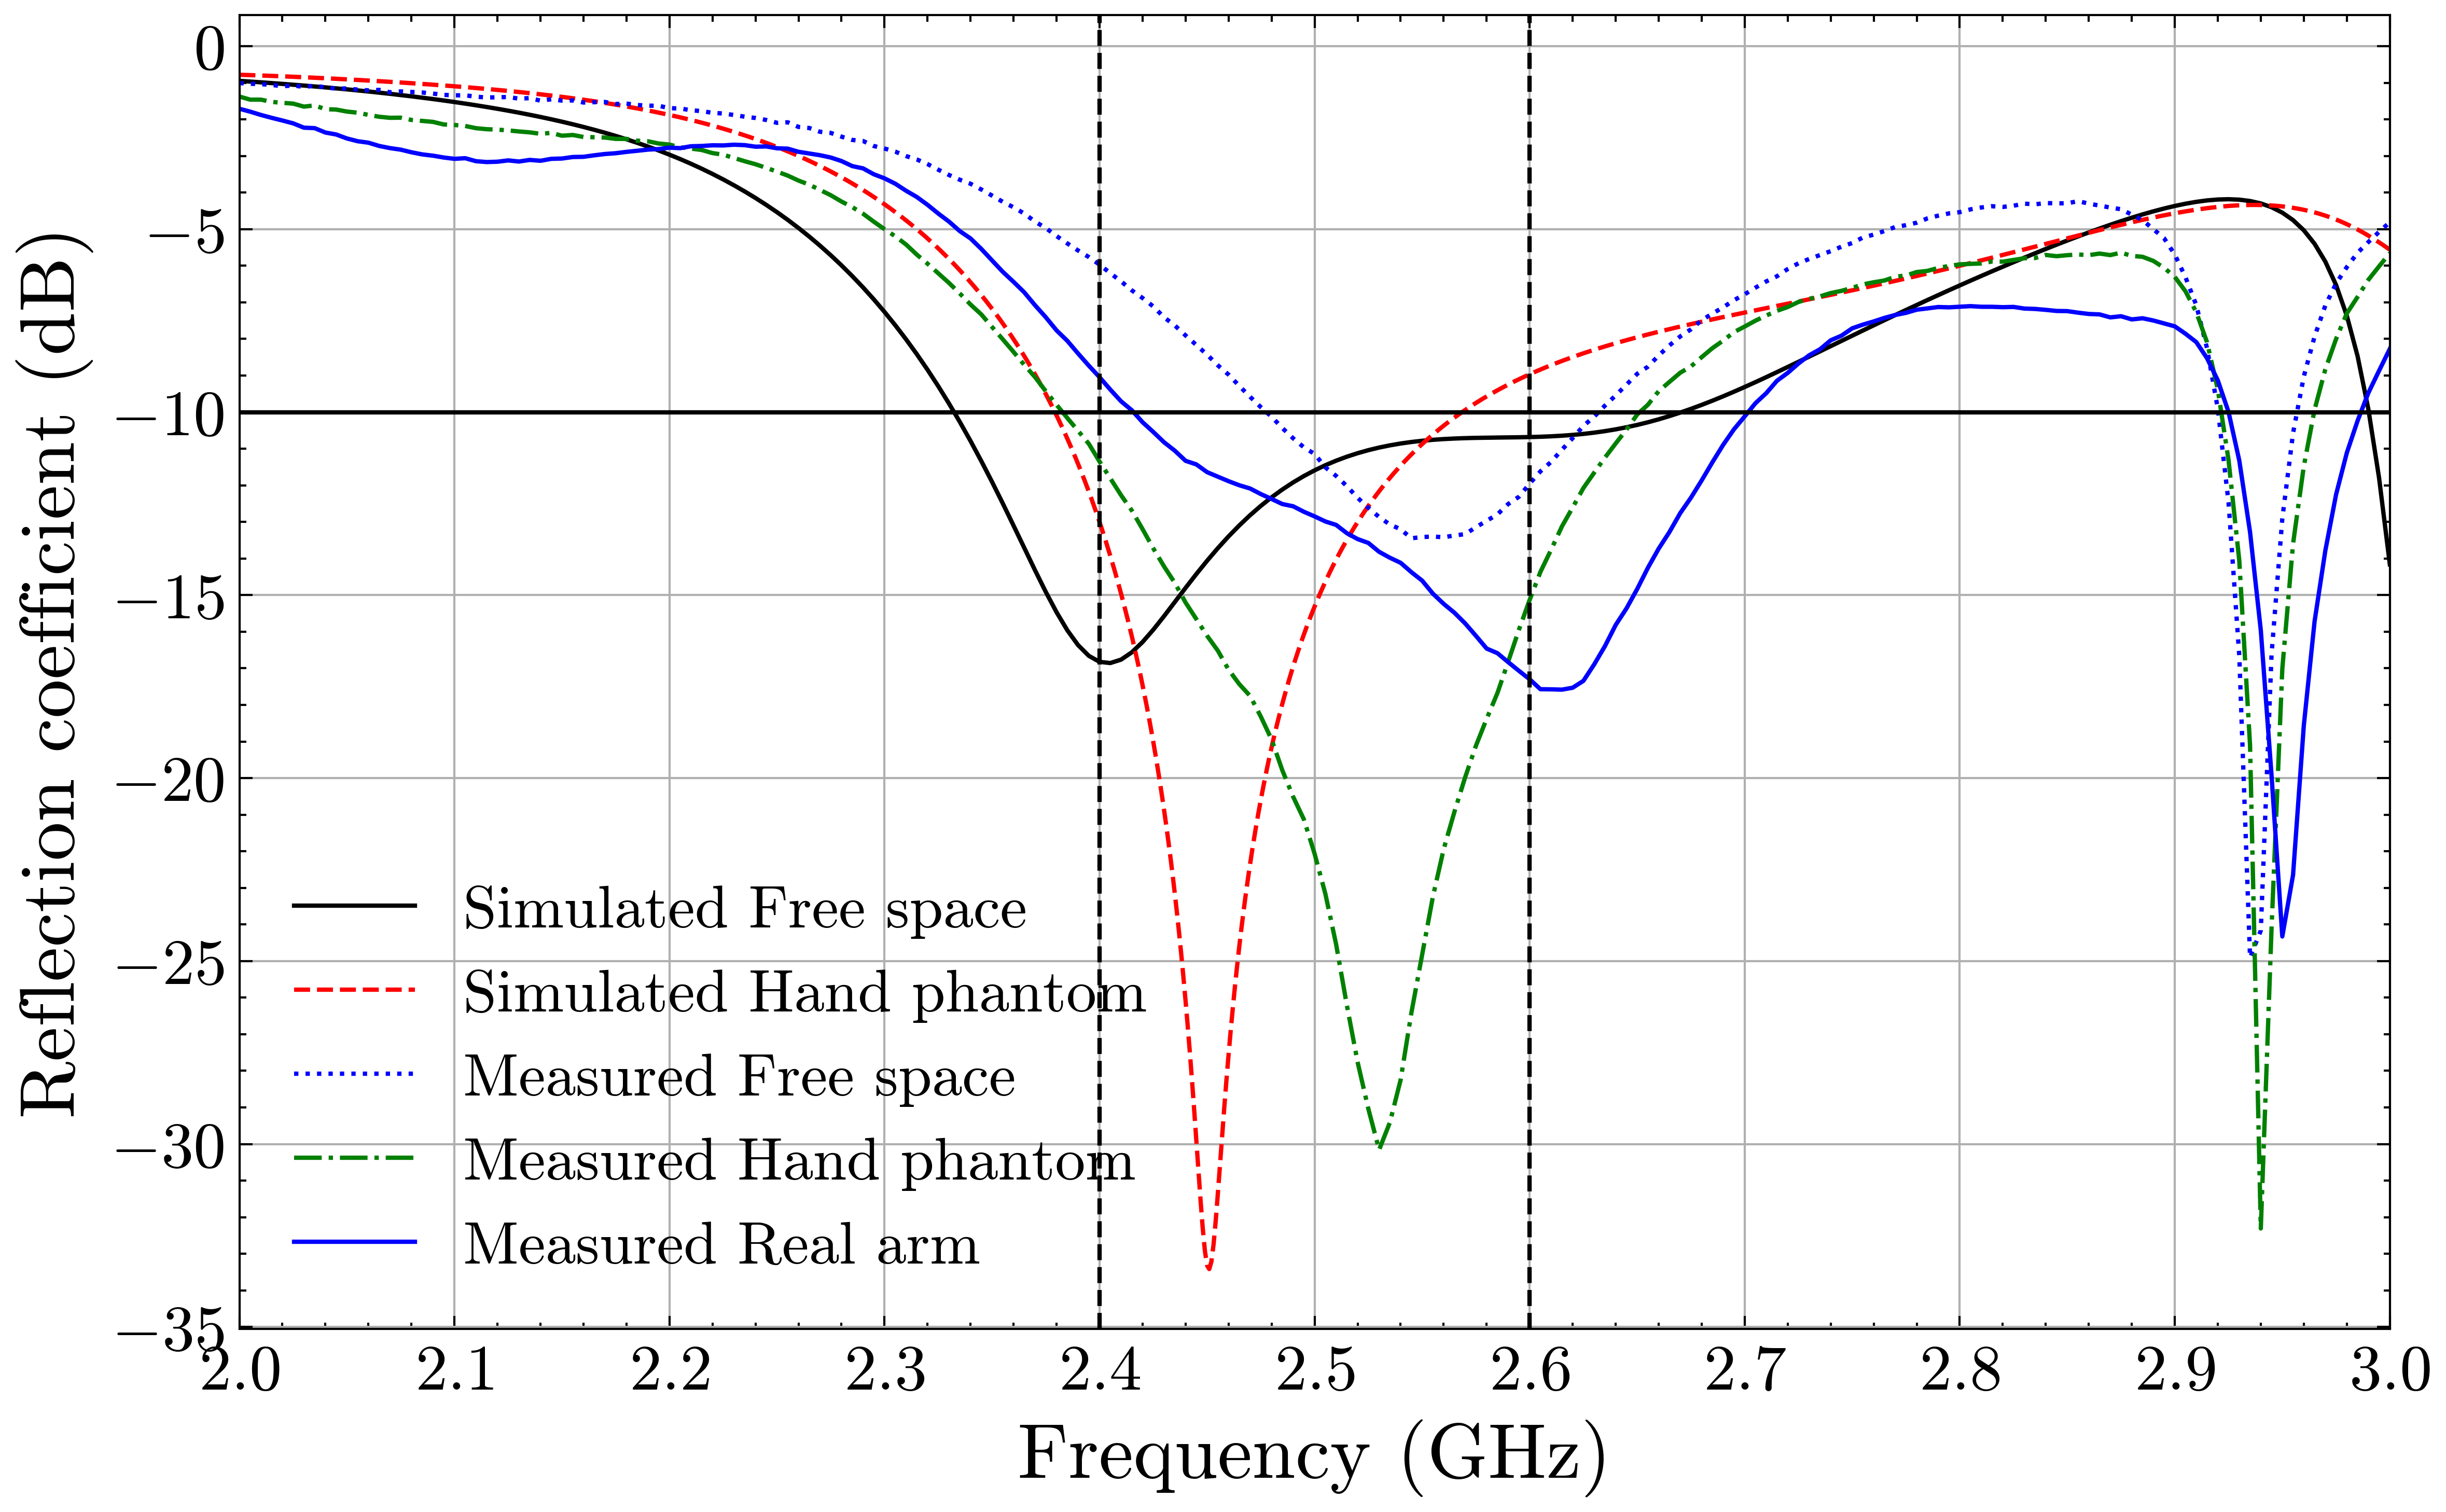

In [8]:
# Interpolate simulated_S11_free_space['Magnitude(dB)'] to match the frequency points of measured data
interpolated_simulated_S11_free_space = np.interp(measured_S11_free_space['Frequency (GHz)'], 
                                                 simulated_S11_free_space['Frequency (GHz)'], 
                                                 simulated_S11_free_space['Magnitude(dB)'])


plt.figure(figsize=(8, 5))
plt.plot(measured_S11_free_space['Frequency (GHz)'], interpolated_simulated_S11_free_space, label='Simulated Free space')
plt.plot(simulated_S11_hand_model[:, 0], simulated_S11_hand_model[:, 1], label='Simulated Hand phantom')
plt.plot(measured_S11_free_space['Frequency (GHz)'], measured_S11_free_space['Magnitude(dB)'], label='Measured Free space')
plt.plot(measured_S11_hand_model['Frequency (GHz)'], measured_S11_hand_model['Magnitude(dB)'], label='Measured Hand phantom')
plt.plot(measured_S11_real_arm['Frequency (GHz)'], measured_S11_real_arm['Magnitude(dB)'], label='Measured Real arm', c='b')

plt.xlabel('Frequency (GHz)', fontsize=18)
plt.ylabel('Reflection coefficient (dB)', fontsize=18)
plt.xticks(fontsize=15)  # Change the fontsize for the x-axis ticks
plt.yticks(fontsize=15) 
plt.xlim(2, 3)
# Add grid lines for each 0.1 GHz step
plt.xticks(np.arange(2, 3.1, 0.1))  # Set x-ticks at every 0.1 GHz

# Add the horizontal solid line at -10 dB
plt.axhline(y=-10, color='black', linestyle='-')

# Add the vertical dotted lines at 2.4 GHz and 2.6 GHz
plt.axvline(x=2.4, color='black', linestyle='--')
plt.axvline(x=2.6, color='black', linestyle='--')


plt.legend(fontsize=14)

plt.grid(True)
plt.tight_layout()

plt.savefig('all_S11.pdf', format='pdf', dpi=600)

## Real arm vs Hand phantom

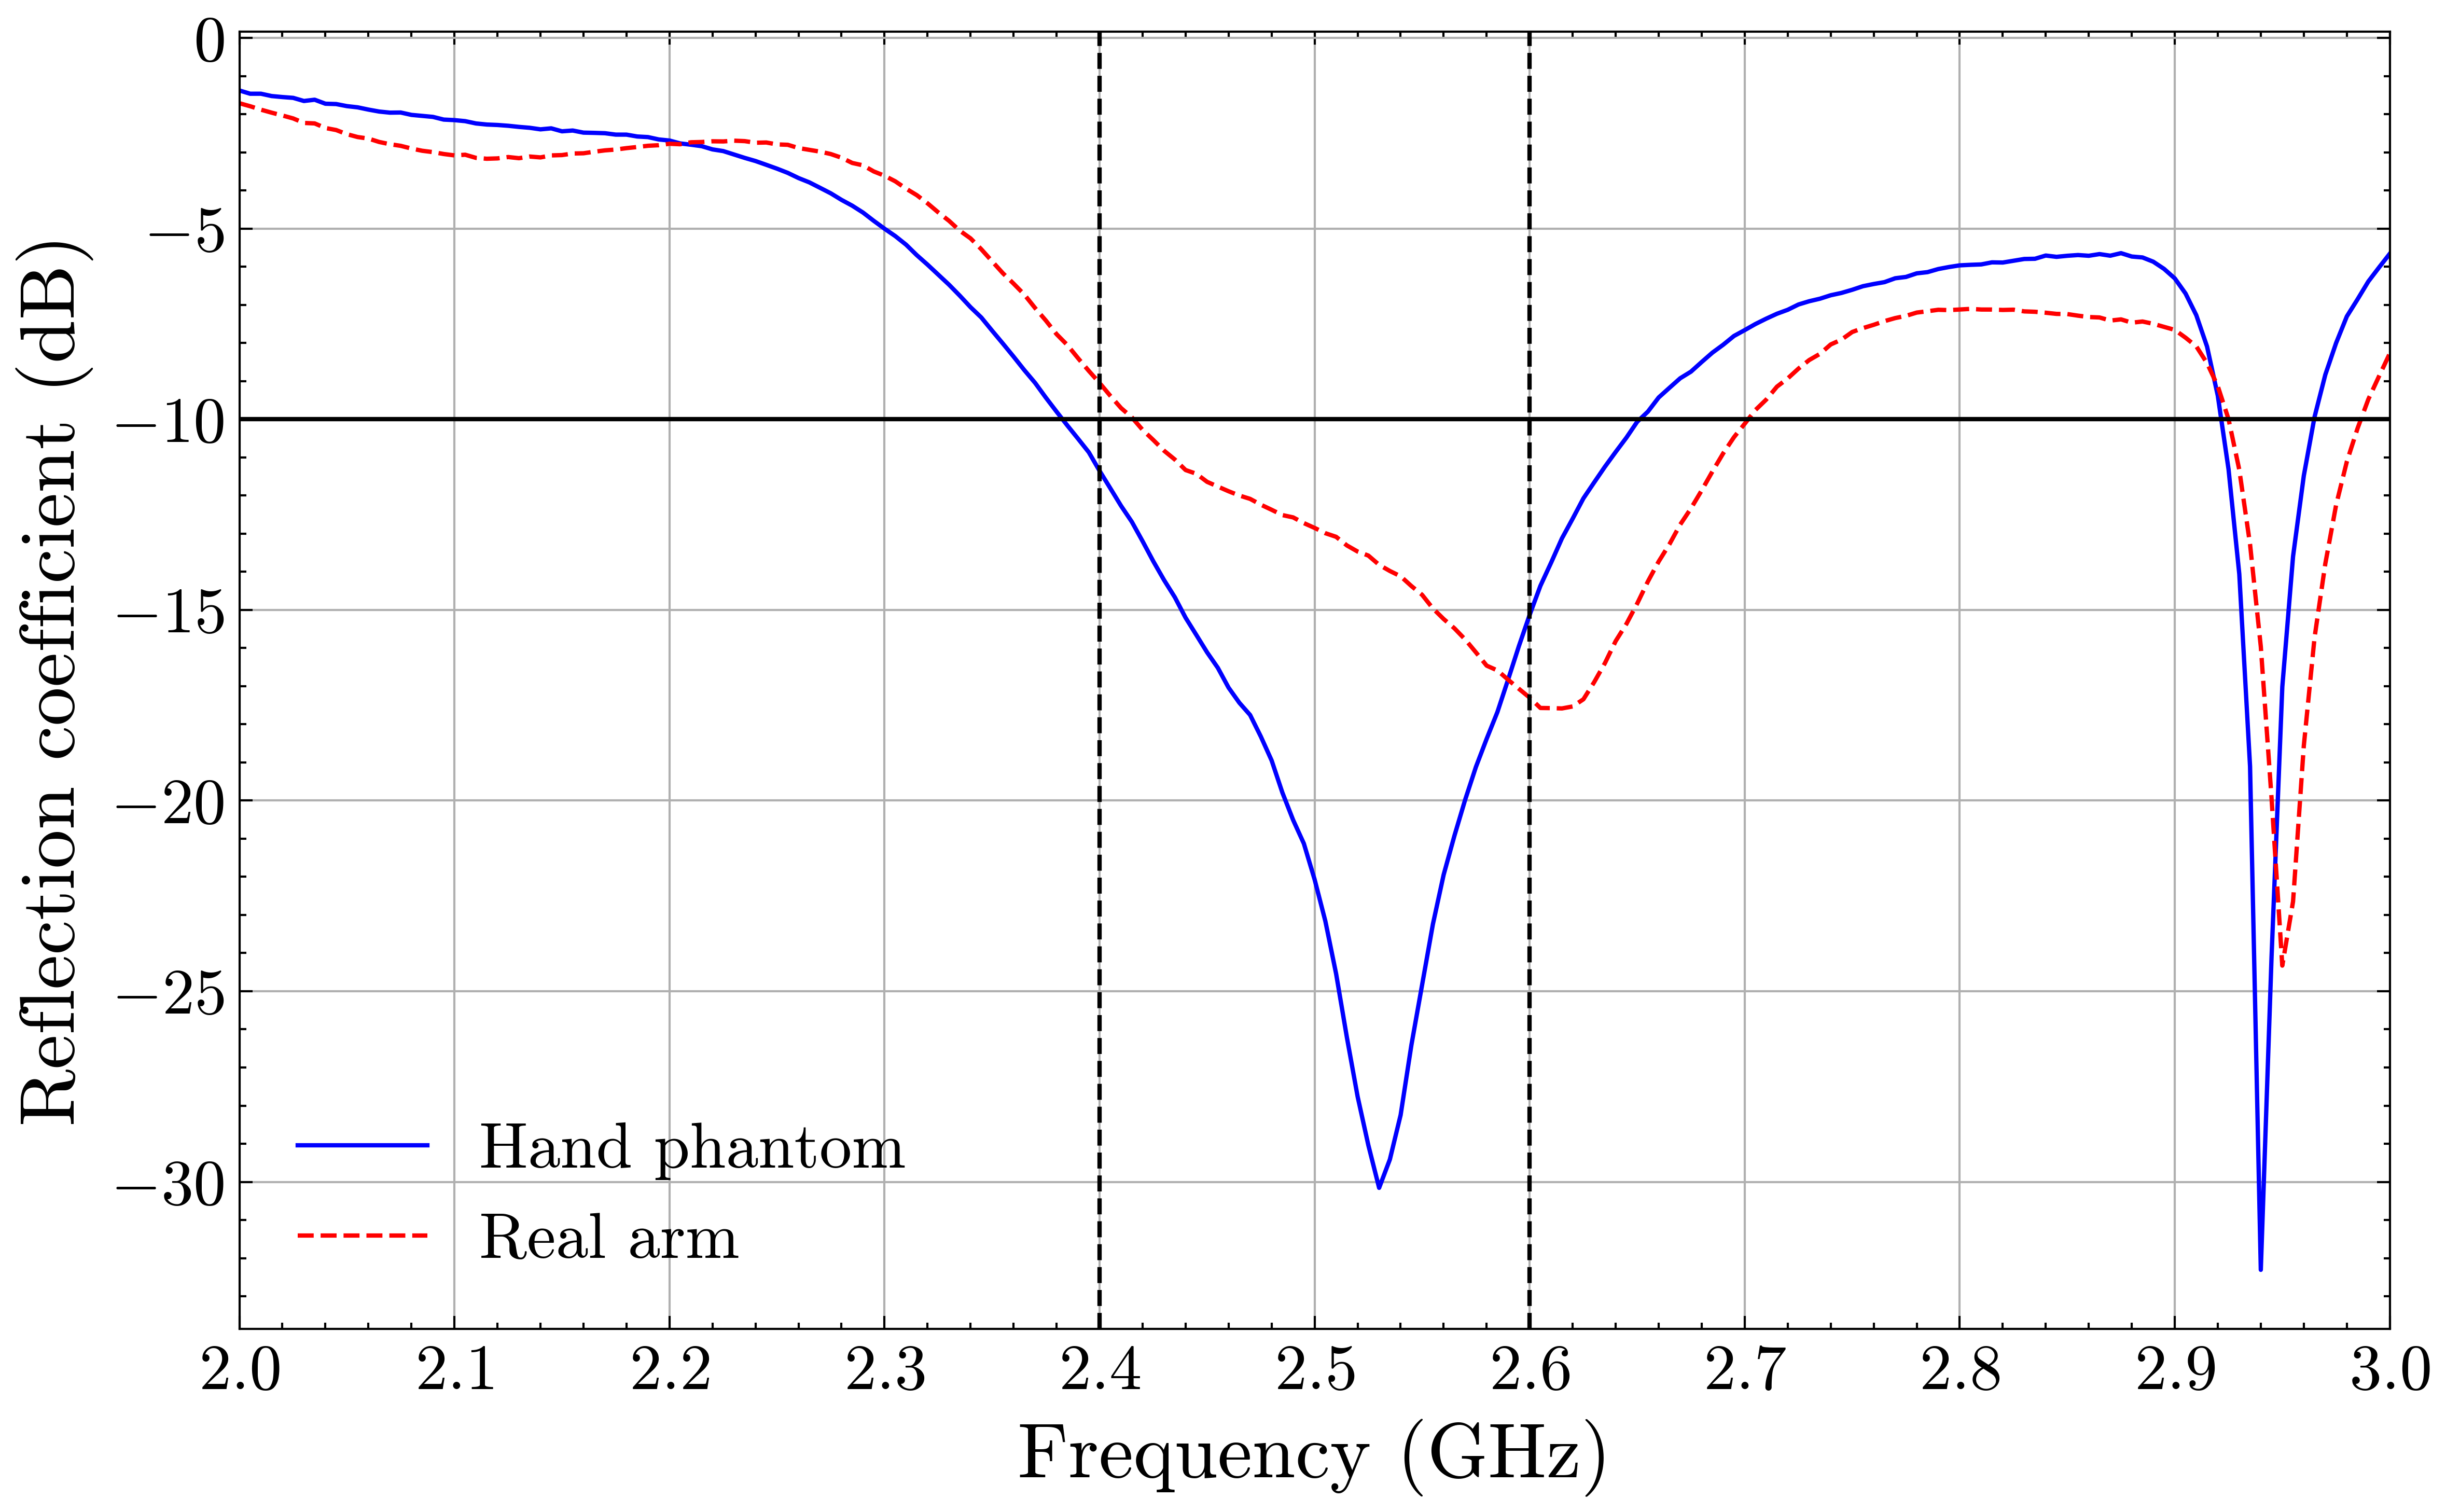

In [6]:
plt.figure(figsize=(8, 5))
plt.plot(measured_S11_hand_model['Frequency (GHz)'], measured_S11_hand_model['Magnitude(dB)'], label='Hand phantom', color='b')
plt.plot(measured_S11_real_arm['Frequency (GHz)'], measured_S11_real_arm['Magnitude(dB)'], label='Real arm', color='r')

plt.xlabel('Frequency (GHz)', fontsize=18)
plt.ylabel('Reflection coefficient (dB)', fontsize=18)
plt.xticks(fontsize=15)  # Change the fontsize for the x-axis ticks
plt.yticks(fontsize=15) 

# Add the horizontal solid line at -10 dB
plt.axhline(y=-10, color='black', linestyle='-')

# Add the vertical dotted lines at 2.4 GHz and 2.6 GHz
plt.axvline(x=2.4, color='black', linestyle='--')
plt.axvline(x=2.6, color='black', linestyle='--')

plt.xlim(2, 3)
plt.xticks(np.arange(2, 3.1, 0.1))  # Set x-ticks at every 0.1 GHz
plt.legend(fontsize=15)

plt.grid(True)
plt.tight_layout()

plt.savefig('Real arm vs Hand phantom.pdf', format='pdf', dpi=600)

## Smith Chart plot

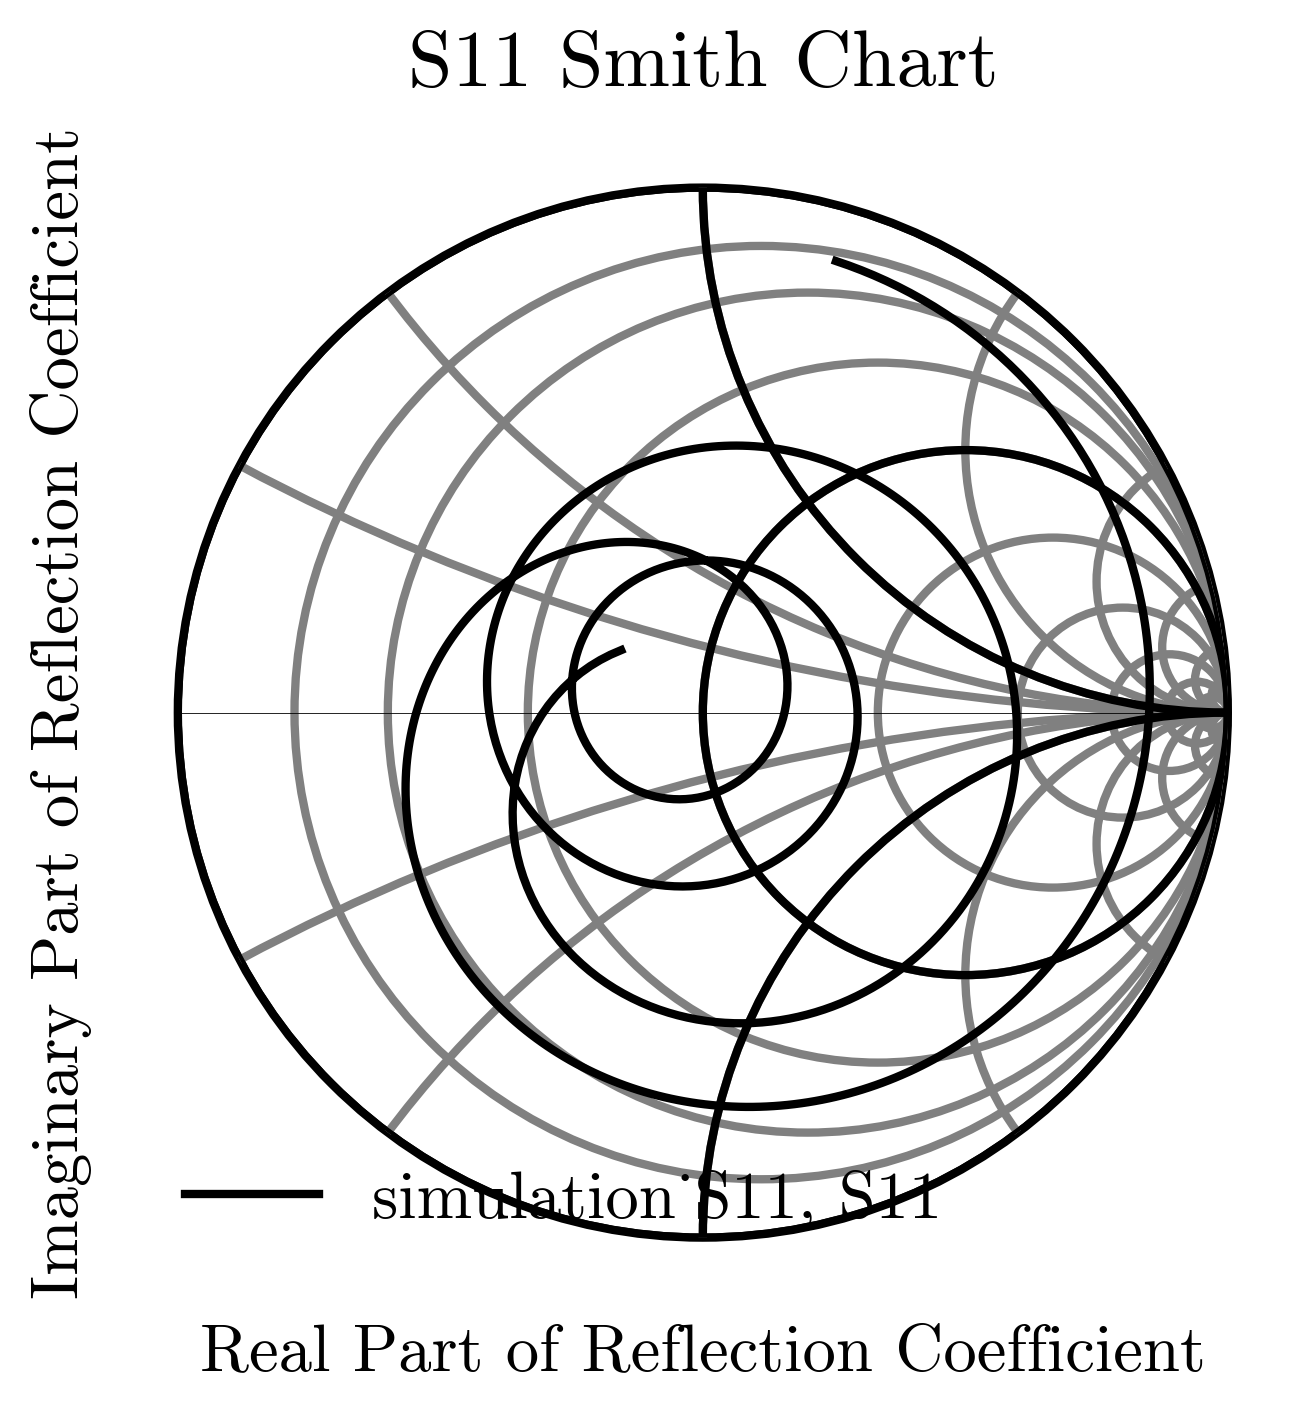

In [9]:
import skrf as rf

network = rf.Network(simulated_S11_free_space_path)

# Plot S11 on a Smith chart
fig, ax = plt.subplots()
network.plot_s_smith(m=0, n=0, ax=ax)  # m=0, n=0 corresponds to S11

# Add labels and title
ax.set_title('S11 Smith Chart')
ax.set_xlabel('Real Part of Reflection Coefficient')
ax.set_ylabel('Imaginary Part of Reflection Coefficient')

# Show the plot
plt.show()

## S11 sweep ideal cap 0.5-0.8pF with realistic inductor 3.6nH

In [36]:
file_path = 'S11_sweep_C1.txt'
data = np.genfromtxt(file_path, skip_header=2)

In [37]:
# Calculate the difference between consecutive rows to find discontinuities in frequency or S11 values
freq_diff = np.diff(data[:, 0])  # Frequency difference between consecutive rows
s11_diff = np.diff(data[:, 1])  # S11 magnitude difference between consecutive rows

# Set thresholds to identify large jumps or changes, which might indicate a boundary between groups
freq_threshold = 0.5  # Set a reasonable threshold for frequency jumps
s11_threshold = 5  # Set a reasonable threshold for S11 jumps

# Find the indices where the changes exceed the thresholds
freq_jump_indices = np.where(np.abs(freq_diff) > freq_threshold)[0]
s11_jump_indices = np.where(np.abs(s11_diff) > s11_threshold)[0]

# Combine the results to identify potential breakpoints
group_boundaries = np.unique(np.concatenate([freq_jump_indices, s11_jump_indices]))

# Add the start and end of the data to the boundaries
group_boundaries = np.concatenate([[0], group_boundaries + 1, [len(data)]])

# Split the data into four groups based on detected boundaries
grouped_data = [data[group_boundaries[i]:group_boundaries[i+1]] for i in range(len(group_boundaries) - 1)]

In [29]:
grouped_data[0][:, 0]

array([2.2   , 2.2006, 2.2012, ..., 2.7988, 2.7994, 2.8   ])

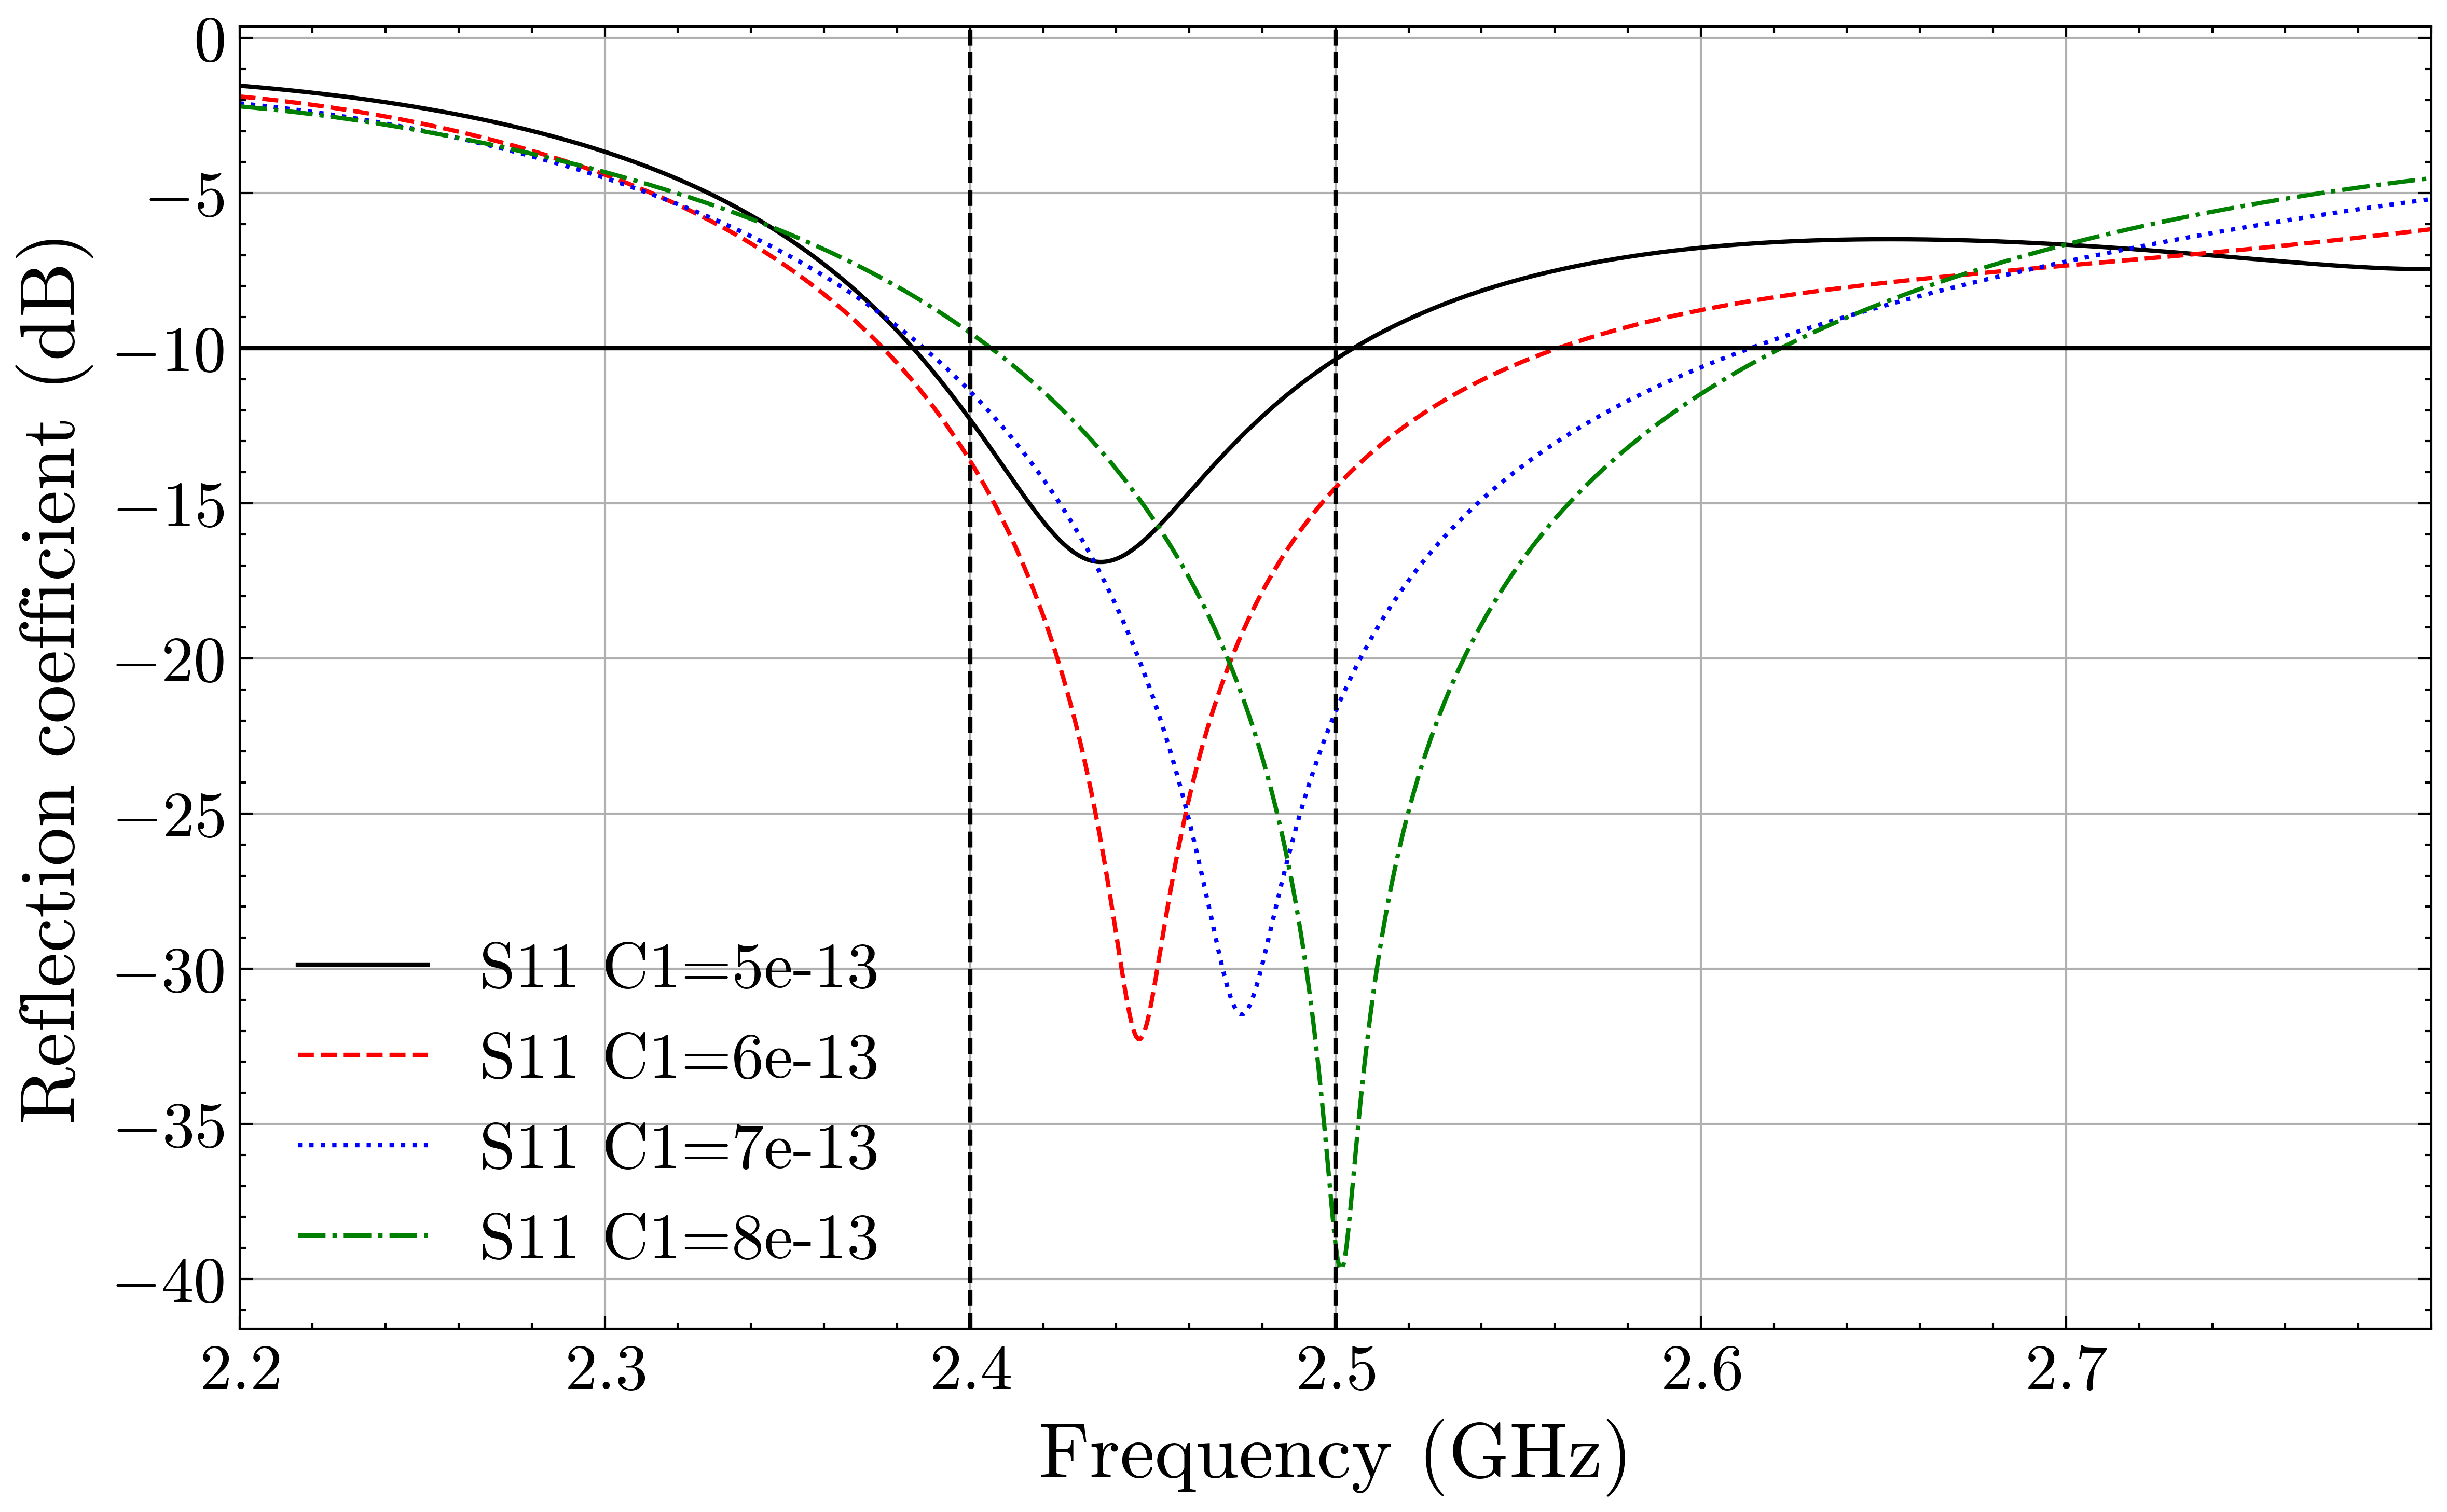

In [37]:
plt.figure(figsize=(8, 5))
plt.plot(grouped_data[1][:, 0], grouped_data[1][:, 1], label='S11 C1=5e-13')
plt.plot(grouped_data[2][:, 0], grouped_data[2][:, 1], label='S11 C1=6e-13')
plt.plot(grouped_data[3][:, 0], grouped_data[3][:, 1], label='S11 C1=7e-13')
plt.plot(grouped_data[0][:, 0], grouped_data[0][:, 1], label='S11 C1=8e-13')

plt.xlabel('Frequency (GHz)', fontsize=18)
plt.ylabel('Reflection coefficient (dB)', fontsize=18)
plt.xticks(fontsize=15)  # Change the fontsize for the x-axis ticks
plt.yticks(fontsize=15) 

plt.xlim(2.2, 2.8)
plt.xticks(np.arange(2.2, 2.8, 0.1))  # Set x-ticks at every 0.1 GHz
plt.legend(fontsize=15)

# Add the horizontal solid line at -10 dB
plt.axhline(y=-10, color='black', linestyle='-')

# Add the vertical dotted lines at 2.4 GHz and 2.6 GHz
plt.axvline(x=2.4, color='black', linestyle='--')
plt.axvline(x=2.5, color='black', linestyle='--')

plt.grid(True)
plt.tight_layout()

plt.savefig('sweep ideal cap 0.5-0.8pF.pdf', format='pdf', dpi=600)

In [42]:
grouped_data[2]

array([[ 2.2       , -1.8875639 ],
       [ 2.2006    , -1.89417532],
       [ 2.2012    , -1.90087708],
       ...,
       [ 2.7988    , -6.18163975],
       [ 2.7994    , -6.17315399],
       [ 2.8       , -6.16464928]])

In [41]:
np.save("S11_simulated_hand_models.npy", grouped_data[2])

In [6]:
file_path = 'S11_structure_sensitivity_analysis.txt'
data = np.genfromtxt(file_path, skip_header=2)

In [20]:
# Calculate the difference between consecutive rows to find discontinuities in frequency or S11 values
freq_diff = np.diff(data[:, 0])  # Frequency difference between consecutive rows
s11_diff = np.diff(data[:, 1])  # S11 magnitude difference between consecutive rows


# Calculate the difference between consecutive rows to find discontinuities in frequency or S11 values
freq_diff = np.diff(data[:, 0])  # Frequency difference between consecutive rows
s11_diff = np.diff(data[:, 1])  # S11 magnitude difference between consecutive rows

# Set thresholds to identify large jumps or changes, which might indicate a boundary between groups
freq_threshold = 0.5  # Set a reasonable threshold for frequency jumps
s11_threshold = 5  # Set a reasonable threshold for S11 jumps

# Find the indices where the changes exceed the thresholds
freq_jump_indices = np.where(np.abs(freq_diff) > freq_threshold)[0]
s11_jump_indices = np.where(np.abs(s11_diff) > s11_threshold)[0]

# Combine the results to identify potential breakpoints
group_boundaries = np.unique(np.concatenate([freq_jump_indices, s11_jump_indices]))

# Add the start and end of the data to the boundaries
group_boundaries = np.concatenate([[0], group_boundaries + 1, [len(data)]])

# Split the data into groups based on detected boundaries
grouped_data = [data[group_boundaries[i]:group_boundaries[i+1]] for i in range(len(group_boundaries) - 1)]

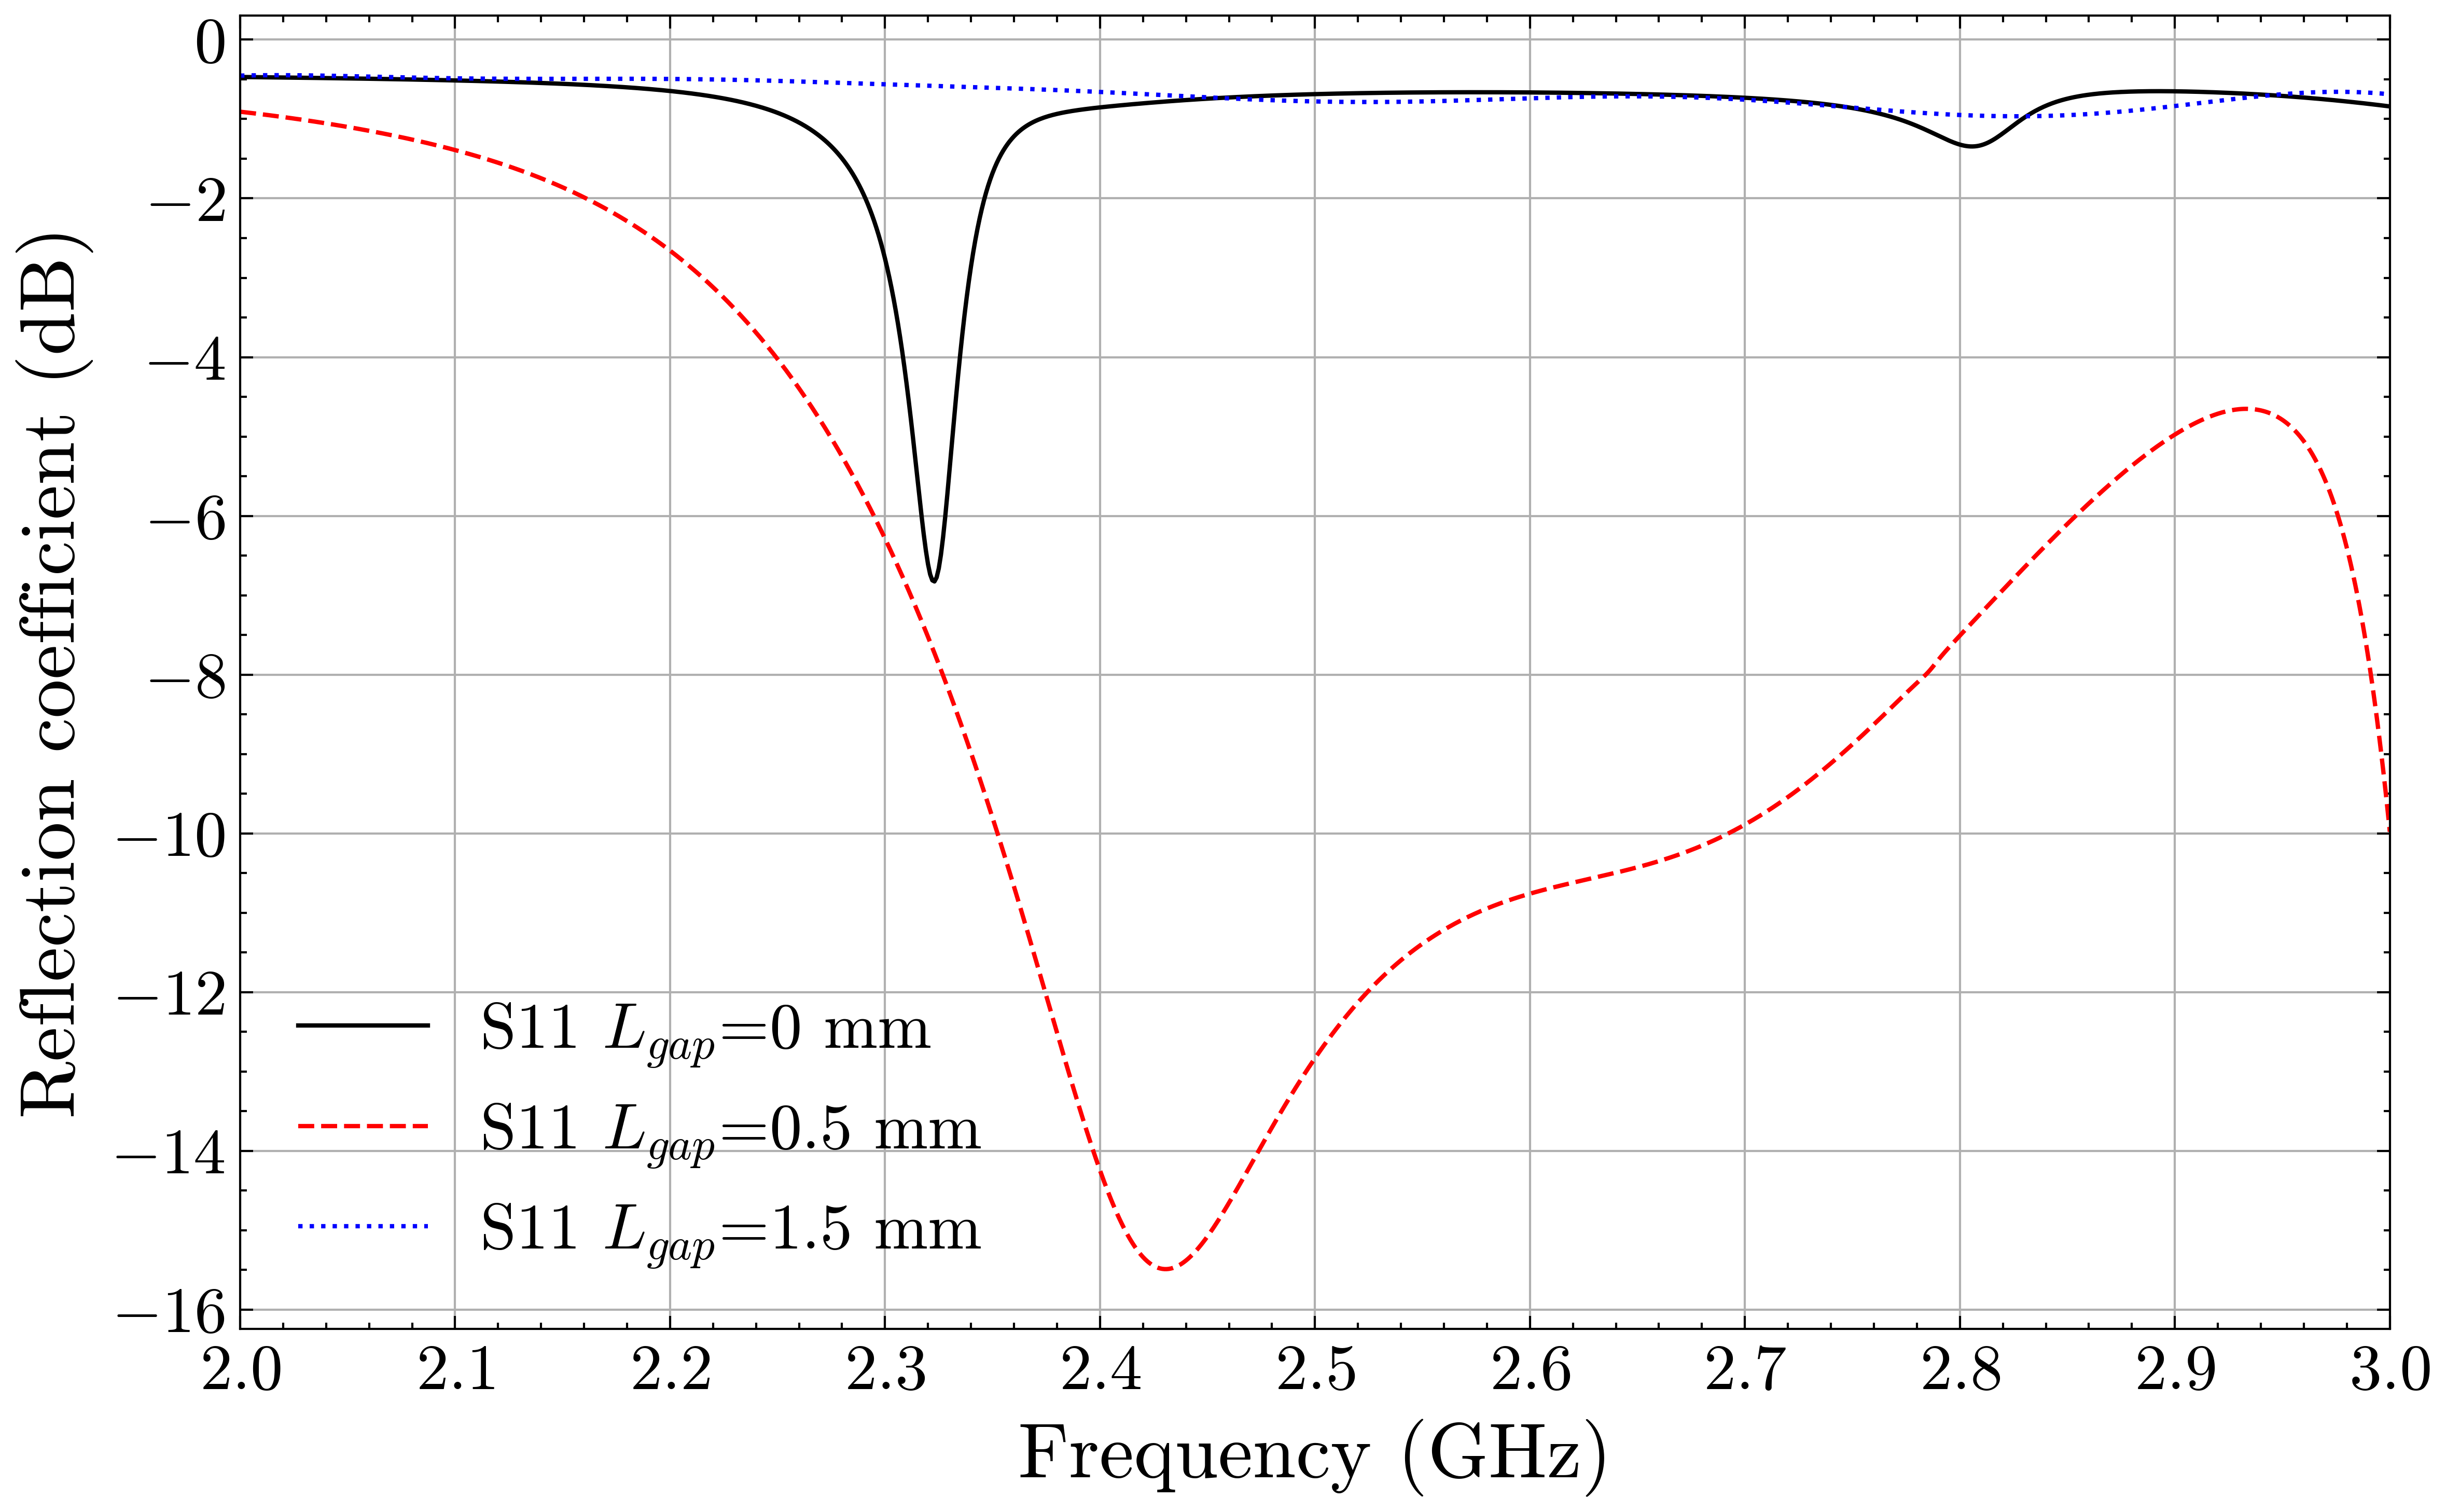

In [30]:
plt.figure(figsize=(8, 5))
plt.plot(grouped_data[0][:, 0], grouped_data[0][:, 1], label='S11 $L_{gap}$=0 mm')
plt.plot(grouped_data[2][:, 0], grouped_data[2][:, 1], label='S11 $L_{gap}$=0.5 mm')
plt.plot(grouped_data[1][:, 0], grouped_data[1][:, 1], label='S11 $L_{gap}$=1.5 mm')

plt.xlabel('Frequency (GHz)', fontsize=18)
plt.ylabel('Reflection coefficient (dB)', fontsize=18)
plt.xticks(fontsize=15)  # Change the fontsize for the x-axis ticks
plt.yticks(fontsize=15) 

plt.xlim(2, 3)
plt.xticks(np.arange(2, 3.1, 0.1))  # Set x-ticks at every 0.1 GHz
plt.legend(fontsize=15)

plt.grid(True)
plt.tight_layout()

plt.savefig('S11_structure_sensitivity_analysis.pdf', format='pdf', dpi=600)

## 3D plot